# LCA for different transport modes with a focus on bicycles

The notebook calculates the life cycle impacts for the EDGE_T internalization.
* Calculate the energy requirement of powering bicycles
* Calculate the impact of nutrition
* Compare these impacts to other modes of transport.

In [2]:
#to-does:

# what is the share of bicycle and walking and ebike?

# adjust preferance factor of non-motorized when ebikes are added 
# they should develop more like motorscooter?

# maybe not consider motobike?


# impact of walking



In [3]:
# known issues
# car load factor is global average
#liquids is only mapped to gasoline not diesel
#active transport modes are not differentiated in REMIND
# ecoinvent processes: 
# transport, passenger car, fleet average, {BEV, FCEV, ICEV-d, ICEV-p, ICEV-g, HEV-d, HEV-p, HEV-g, PHEV-d, PHEV-p, PHEV-g}, <year>, -d = Diesel, -p = Petrol, -g = Gas

In [4]:
# sector impacts
# ES|Transport|VKM|Pass|Road|LDV|{BEV, FCEV, Gases, Hybrid Electric, Hybrid Liquids, Liquids}
# die Variablen ohne das VKM sind die pkms

In [206]:
import pickle
pickle.HIGHEST_PROTOCOL = 4
import pandas as pd
import numpy as np
import math as ma
import warnings
import matplotlib.pyplot as plt

import pprint
import brightway2 as bw
import bw2io
import seaborn as sn
import json

%run -i ./script/helpers.py


warnings.filterwarnings('ignore')

year = 2030
scenario = "bike-lca_lca_Budg1100_ElecPush"

# xxxx change to elecera plus lifestyle

remind_report        = "data\\remind\\Budg1100_ElecEra_2020-09-17_17.17.49\\REMIND_generic_Budg1100_ElecEra_withoutPlus.mif"
lca_database         = "data\\lca\\brightway2-project-bike-lca_lca_Budg1100_ElecPush-backup.22-January-2021-08-54PM.tar.gz"
magpie_report        = "data\\magpie\\magpie_C_SDP-PkBudg1100-mag-4.mif"
literature_report    = "data\\bicycles_rule_plot_source.csv"
air_pollution_report = "data\\air_pollution\\results_dalys_SSP2_Budg1100_ElecEra_SSP2_IIASA_aneris_downscaling_.csv"
region_mapping_path  = "data\\regionmappingH12.csv"

edgetransport_moto_path       = "data\\edgeTransport\\EDGE_transport_moto_non_energy_cost.csv"
edgetransport_non_moto_path   = "data\\edgeTransport\\EDGE_transport_non_moto.csv"
edgetransport_load_factor_path= "data\\edgeTransport\\loadFactor.csv"


gbd_location_mapping_path = "data\\GBD\\location_mapping.csv"
gbd_measure_mapping_path  = "data\\GBD\\measure_mapping.csv"
gbd_rei_mapping_path      = "data\\GBD\\rei_mapping.csv"
gbd_cause_mapping_path    = "data\\GBD\\cause_mapping.csv"
gbd_metric_mapping_path   = "data\\GBD\\metric_mapping.csv"

noise_eea_paths           = "data\\noise\\EEA_noise.csv"

GBD_path             = "data\\GBD\\GBD.json"

#obsolete
urban_population = "data\\pop.mif"

In [6]:
# read REMIND energy results
remind = pd.read_csv(remind_report, sep=';')

In [7]:
# read REMIND lca results
bw.restore_project_directory(lca_database)

Restoring project backup archive - this could take a few minutes...


'bike-lca_lca_Budg1100_ElecPush'

In [8]:
bw.projects.set_current(scenario)
bw.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cutoff
	ecoinvent_remind_Budg1100_ElecPush_2020
	ecoinvent_remind_Budg1100_ElecPush_2025
	ecoinvent_remind_Budg1100_ElecPush_2030
	ecoinvent_remind_Budg1100_ElecPush_2035
	ecoinvent_remind_Budg1100_ElecPush_2040
	ecoinvent_remind_Budg1100_ElecPush_2050

In [9]:
ei = bw.Database("ecoinvent_remind_Budg1100_ElecPush_" + str(year))

In [10]:
#transport, passenger car, fleet average, {BEV, FCEV, ICEV-d, ICEV-p, ICEV-g, HEV-d, HEV-p, HEV-g, PHEV-d, PHEV-p, PHEV-g}, <year>, -d = Diesel, -p = Petrol, -g = Gas
#ES|Transport|VKM|Pass|Road|LDV|{BEV, FCEV, Gases, Hybrid Electric, Hybrid Liquids, Liquids}

### Calculation of kcal/km bicycle

The energy requirements of a bicycle are mainly determined by the gravity, rolling recistance, mechanic loss and, most importantly, aerodynamic drag.

slope assumed to be zero since commutes begin and end at the same elevation.
$\qquad F_{\mbox{gravity}} = g0 \sin(\arctan(\frac{s}{100})) w = 0 \\
\text{where $g0$ = gravitational acceleration, $s$ = slope and $w$ = weight of rider and bike}$ 

rolling resistance
$\qquad F_{\mbox{rolling}} = g0 \cos(\arctan(\frac{s}{100})) w c_{r} \\
\text{where $c_r$ = coefficient of rolling resistance}$

Aerodynamic drag
$\qquad F_{\mbox{aero}} = 0.5 c_{d} A \rho V^2 \\
\text{where $c_{d}$ = drag coefficient, $A$ = frontal area, $\rho$= air density and $V$ is speed}$

Power supply by rider:
$\qquad P_{\mbox{rider}} = c_{b} \left[F_{\mbox{gravity}} + F_{\mbox{rolling}} + F_{\mbox{aero}}\right] V \\
\text{where $c_{b}$ = bike efficiency, drivetrain losses and others}$

Food intake:
$\qquad E_{rider} = (P_{\mbox{rider}} \frac{d}{V}) \frac{1}{c_{m}} \\
\text{where $d$ = distance, $c_{m}$ is the muscular efficiency}$ 


do we need to give sources for formulas, they seem quite obvious

Take Frontal Area and Drag Coeff from 
file:///C:/Users/rauner/AppData/Local/Temp/Aerodynamic_drag_in_cycling_Methods_of_assessment.pdf

Muscular efficiency:
https://www.researchgate.net/publication/22014772_Muscular_efficiency_during_steady-rate_exercise_effects_of_speed_and_work_rate

This gives around 15 kcal


In [11]:
ws2kcal = 1/4184
g0 = 9.8067 # m/s2
roh = 1.22601 # kg/m3

s = 0 # %
w = 70 # kg
a = 0.5 # m2

v = 6 # m/2
d = 1000 # m

cr = 0.005
cd = 0.6
cb = 0.05
cm = 0.2


E = (((1-cb)*((g0*ma.sin(ma.atan(s/100))*w)+(g0*ma.cos(ma.atan(s/100))*w*cr)+(0.5*cd*a*roh*pow(v,2)))*v)*d/v)*1/cm * ws2kcal

print("{:.2f} kcal/km of food intake required".format(E))

#see https://www.fitness-gesundheit.uni-wuppertal.de/fileadmin/fitness-gesundheit/pdf-Dokumente/Publikationen/2013/WasistMET_S.82-83.pdf
MET_minutes = E/1.2  
print("{:.2f} MET minutes required".format(MET_minutes))

11.41 kcal/km of food intake required
9.51 MET minutes required


In [12]:
# Add walking
# take the regression model from https://journals.lww.com/nsca-jscr/Fulltext/2010/10000/Comparison_of_Energy_Expenditure_to_Walk_or_Run_a.29.aspx
# read the kg average body weight from magpie and apply to this formula

#E_walking = (mass (kg) × 0.789 - gender (men = 1, women = 2) × 7.634 + 51.109) / 1.6


### Diet to fuel cycling and ebike

The diet plays a crucial role for the impact of bicycles. We model the nutrition demand and supply with the MAGPIE model. We use the same climate budget and assume a EAT-LANCET low waste diet adoption until 2050.

In [13]:
# Calculate a kcal share mix according to the MAGPIE results
# Calculate a demand/supply share
# Calulate the lca for that
cal2kj = 4.184


In [14]:
#select which nutrition processes are included
#determine their kg/kcal
#see
%run -i ./script/diet_mappings.py

In [15]:
# fill a list with activities present in the magpie_ecoinvent_nutrition_mapping_simple
activities=[]
for value in magpie_ecoinvent_nutrition_mapping_extended.values():
        activities.append([act for act in ei if act['name']==str(value).split("'",2)[1] and 'GLO' in act['location']][0])

#create a new nutrition activity for the 
nutrition = ei.new_activity(code = 'nutrition', name = "Nutrition mix, EAT-Lancet diet convergance in 2050", unit = "kcal")

print("the nutrition consists of:")

#loop over included nutition activities and add amount
for i in range(len(activities)-1):
    act= str(activities[i])
    print(act)

    amt = magpie_intake.query("Variable == @act")[str(year)]
    amt = pd.to_numeric(amt, errors='coerce')
    if(ma.isnan(amt.values[0])):
        amt.values[0] = 0
    print(amt.values[0])

    nutrition.new_exchange(input=activities[i].key,amount=amt.values[0],unit="kg/kcal",type='technosphere').save()

nutrition.save()


the nutrition consists of:
'market for fishmeal, 65-67% protein' (kilogram, GLO, None)
6.9908745247148295e-06
'market for maize seed, organic, at farm' (kilogram, GLO, None)
1.0389942877763694e-05
'market for rice, non-basmati' (kilogram, GLO, None)
0.00010836388157680935
'market for wheat grain, feed' (kilogram, GLO, None)
3.908248216903998e-05
'market for peanut' (kilogram, GLO, None)
7.664178754166081e-06
'market for apple' (kilogram, GLO, None)
0.00013447994865295248
'market for potato' (kilogram, GLO, None)
2.00564032503196e-05
'market for chickpea' (kilogram, GLO, None)
1.0348285396870104e-05
'market for potato' (kilogram, GLO, None)
2.00564032503196e-05
'market for sugar beet pulp' (kilogram, GLO, None)
5.109008557589333e-09
'market for sugar, from sugarcane' (kilogram, GLO, None)
2.162297378427056e-07
'market for dairy' (cubic meter, GLO, None)
1.5234767913888427e-07
'chicken production' (kilogram, GLO, None)
1.1301904685935106e-05
'market for swine for slaughtering, live weigh

### Transport modes to perform LCA on

In [16]:
#transport modes to perform lca on
ecoinvent_activity_transport =        ["transport, passenger car, fleet average, BEV, "  + str(year),
                                       "transport, passenger car, fleet average, FCEV, "   + str(year),
                                       "transport, passenger car, fleet average, ICEV-g, "   + str(year),
                                       "transport, passenger car, fleet average, PHEV-p, "   + str(year),
                                       "transport, passenger car, fleet average, HEV-p, "   + str(year),
                                       "transport, passenger car, fleet average, ICEV-p, "   + str(year),
                                       "market for transport, passenger train", 
                                       "market for transport, regular bus",
                                       "market for transport, passenger, motor scooter",
                                       "market for transport, passenger, bicycle",
                                       "market for transport, passenger, electric bicycle"]



In [17]:
#corresponding REMIND activities
REMIND_activity_transport =           ["transport, passenger car, fleet average, BEV, "  + str(year),
                                       "transport, passenger car, fleet average, FCEV, "   + str(year),
                                       "transport, passenger car, fleet average, ICEV-g, "   + str(year),
                                       "transport, passenger car, fleet average, PHEV-p, "   + str(year),
                                       "transport, passenger car, fleet average, HEV-p, "   + str(year),
                                       "transport, passenger car, fleet average, ICEV-p, "   + str(year),
                                       "market for transport, passenger train", 
                                       "market for transport, regular bus",
                                       "market for transport, passenger, motor scooter",
                                       "market for transport, passenger, bicycle",
                                       "market for transport, passenger, electric bicycle"]

In [18]:
# fill a list with the relevant ecoinvent activities
acti = {}

for i in range(len(ecoinvent_activity_transport)):
    activity = str(ecoinvent_activity_transport[i])
    print(activity)
    
    acti[activity] = [act for act in ei if activity in act["name"]]

    

transport, passenger car, fleet average, BEV, 2030
transport, passenger car, fleet average, FCEV, 2030
transport, passenger car, fleet average, ICEV-g, 2030
transport, passenger car, fleet average, PHEV-p, 2030
transport, passenger car, fleet average, HEV-p, 2030
transport, passenger car, fleet average, ICEV-p, 2030
market for transport, passenger train
market for transport, regular bus
market for transport, passenger, motor scooter
market for transport, passenger, bicycle
market for transport, passenger, electric bicycle


In [19]:
car_load_factor = 2.03 # UCD transport database global average, not chaning in the future

In [20]:
# calculate the lci and lca for the activities in acti

# for LDV transfer kilometer to person kilometer
# for bikes and ebikes add nutrition

lca = {}
impact_category = ('IPCC 2013', 'climate change', 'GWP 100a')
for i in acti:
  
        for e in acti[i]:

            lca[e] = bw.LCA({e: 1}, (impact_category))
            lca[e].lci()
            lca[e].lcia()
            lca[e].score
            print(str(e) + ': '+  str(lca[e].score) + ' ' + str(impact_category))



'transport, passenger car, fleet average, BEV, 2030' (kilometer, REF, None): 0.17661673944382894 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, SSA, None): 0.11994160887877293 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, NEU, None): 0.09718413182456322 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, JPN, None): 0.12645747932193285 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, OAS, None): 0.1762302427396655 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CHA, None): 0.13608040714814418 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CAZ, None): 0.10663988944803783 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, pa

'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, LAM, None): 0.21895908584252013 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, REF, None): 0.24244723384248448 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, SSA, None): 0.2625769663793895 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, OAS, None): 0.273194753664724 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, USA, None): 0.3129823262106689 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, CHA, None): 0.27990809644622416 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, EUR, None): 0.28733572674166225 ('IPCC 2013', 'climate change', 'GWP 100a'

In [21]:
car_load_factor

2.03

In [22]:
# calculate the lci and lca for the activities in acti

# for LDV transfer kilometer to person kilometer
# for bikes and ebikes add nutrition

lca = {}
impact_category = ('IPCC 2013', 'climate change', 'GWP 100a')
for i in acti:
  
        for e in acti[i]:
            lca[e] = bw.LCA({e: 1}, (impact_category))
            
            if 'car' in str(e):
                lca[e] = bw.LCA({e: 1}, (impact_category))
                
            if 'passenger, bicycle' in e:
                lca[e] = bw.LCA({e: 1, nutrition: E}, (impact_category))   
        
                # this nutrition requirement is only an estimate, find better source
            if 'passenger, electric bicycle' in e:
                lca[e] = bw.LCA({e: 1, nutrition: 5}, (impact_category)) 

            lca[e].lci()
            lca[e].lcia()
            lca[e].score
            print(str(e) + ': '+  str(lca[e].score) + ' ' + str(impact_category))



'transport, passenger car, fleet average, BEV, 2030' (kilometer, REF, None): 0.17661673944382894 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, SSA, None): 0.11994160887877293 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, NEU, None): 0.09718413182456322 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, JPN, None): 0.12645747932193285 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, OAS, None): 0.1762302427396655 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CHA, None): 0.13608040714814418 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CAZ, None): 0.10663988944803783 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, pa

'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, LAM, None): 0.21895908584252013 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, REF, None): 0.24244723384248448 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, SSA, None): 0.2625769663793895 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, OAS, None): 0.273194753664724 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, USA, None): 0.3129823262106689 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, CHA, None): 0.27990809644622416 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, EUR, None): 0.28733572674166225 ('IPCC 2013', 'climate change', 'GWP 100a'

### Other impact dimensions

Let's look at a range of dimensions using RECIPE indicators.

In [23]:
def modes(lca):
    lca_impacts = {}
    fd   = pd.DataFrame()



    for i in lca:
      
        for m in methods:
        
            lca[i].switch_method(m)    
            lca[i].lcia()
            lca_impacts[m[1]] = lca[i].score

            
        full = pd.DataFrame.from_dict(lca_impacts, orient="index",  columns=[str(i)])
        fd[str(i)]=full[str(i)]
        
        fd.index.name = "indicator"
        fd.columns.name = "transport mode"
    return fd

In [24]:
methods = [m for m in bw.methods if "ReCiPe Midpoint (H) V1.13" in str(m) and "w/o LT" not in str(m) and "no LT" not in str(m)]
data = modes(lca)
data.to_csv("results/impact_pkm_"+str(year)+".csv")

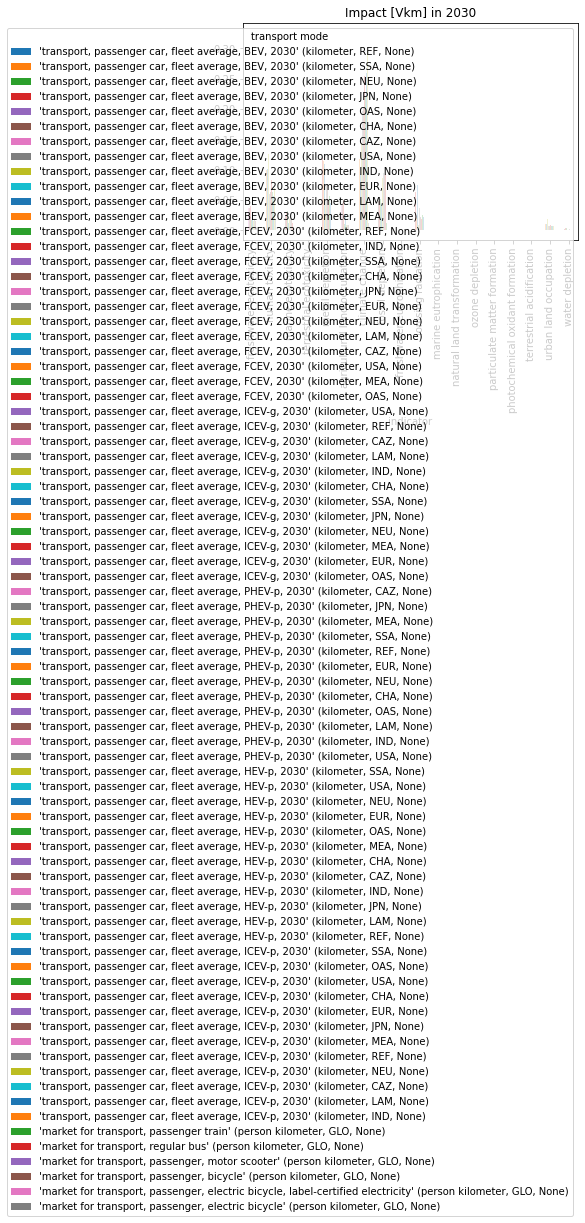

In [25]:
data.plot.bar()
plt.title('Impact [Vkm] in ' + str(year))
plt.savefig("plot/impact_pkm_"+str(year)+".pdf", bbox_inches='tight')

## Calc indicators not in the model and add them to the plot

In [26]:
# calculate the air pollution of the relevant sectors LDV pass road and bus
air_pollution = pd.read_csv(air_pollution_report, sep=';')
%run -i ./script/air_pollution_inter.py

In [27]:
# this is the literature review of non-LCA impacts
literature = pd.read_csv(literature_report, sep=';')

literature
#%run -i ./script/lit_inter.py



,Unnamed: 0,Unnamed: 1,dimension,source,period,region,scaling cost,scaling_cost_period,scaling variable_1,scaling variable_1_period,scaling variable_2,scaling variable_2_period,scaling issues,variable,unit,value_lit,cetrainty,value,plot
0,Health,Direct,Physical Activity,\cite{Stanaway2018},2017.0,glo,NaN,NaN,NaN,NaN,urban_bike_pop_2030/pop_2017,2030;2017,NaN,Physical_activity_health_impact_GBD,DALY,2.400000e+07,medium,NaN,modeling
1,Health,Direct,Physical Activity,\cite{Stanaway2018},2017.0,glo,NaN,NaN,NaN,NaN,urban_bike_pop_2030/pop_2013,2030;2017,NaN,Physical_activity_health_impact_GBD,premature death,1.300000e+06,medium,NaN,modeling
2,Health,Direct,Physical Activity health care cost,\cite{WorldHealthOrganization2018},2013.0,glo,inflation 2013 - 2005,2013;2005,NaN,NaN,urban_bike_pop_2030/pop_2013,2030;2013,NaN,Physical_activity_health_care_cost_WHO,$,4.695652e+10,medium,NaN,modeling
3,Health,Direct,Physical Activity health care cost,\cite{Hamilton2021},2040.0,glo,NaN,NaN,NaN,NaN,urban_bike_pop_2030/pop_2040,2030;2040,NaN,Physical_activity_health_impact_lancet,premature death,3.800000e+06,medium,NaN,modeling
4,Health,Direct,Mental,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
5,Health,Direct,Road safety,\cite{Stanaway2018},2019.0,glo,NaN,NaN,ES|Transport|VKM|Pass|Road|LDV,2019;2030,urban_bike_pop_2030/pop_2019,2030;2019,might overestimate because accidents are lower...,Road_accidents,DALY,7.300000e+07,medium,NaN,modeling
6,Health,Direct,Road safety,\cite{Stanaway2018},2019.0,glo,NaN,NaN,ES|Transport|VKM|Pass|Road|LDV,2019;2030,urban_bike_pop_2030/pop_2019,2030;2019,might overestimate because accidents are lower...,Road_accidents,premature death,1.200000e+06,medium,NaN,modeling
7,Health,Indirect,Road noise,\cite{Organization2011},2010.0,EU,NaN,NaN,ES|Transport|VKM|Pass|Road|LDV,2019;2030,urban_bike_pop_2030/pop_2010_EU,2030;2010,might overestimate because elec cars are less ...,Road_noise,DALY,1.300000e+06,medium,NaN,modeling
8,Health,Indirect,Air pollution,model,NaN,NaN,NaN,NaN,NaN,NaN,scale TM5 health impact with (vkm ldv) / (vkm ...,NaN,NaN,NaN,NaN,NaN,high,NaN,modeling
9,Climate,Low emissions,NaN,model,2030.0,glo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GHG_emissions,CO2eq,NaN,high,NaN,modeling


In [551]:
# load the GBD data and join it with mappings
%run -i ./script/load_gbd.py

# low physical activity
%run -i ./script/low_physical_activity.py
df_low
#rename value and unit for all of them
df_low =df_low.rename(columns={"value": "Value_low", "Unit": "Unit_low"})

# assigne the benefit to bicycles and walking depending on their MET per pkm

# road safety
%run -i ./script/road_safety.py
df_acc_remind
df_acc_remind =df_acc_remind.rename(columns={"value": "Value_acc", "Unit": "Unit_acc", "year": "Period", "remind": "Region"})

# noise
%run -i ./script/noise.py
df_noise
df_noise =df_noise.rename(columns={"value": "Value_noise", "Unit": "Unit_noise", "year": "Period", "remind": "Region"})

# tire wear use this in the total processing
%run -i ./script/tire_wear.py
remind_tire['Variable'] = 'Plastic emissions tires'
remind_tire =remind_tire.rename(columns={"value": "Value_tire_plastic", "Unit": "Unit_tire_plastice"})
remind_tire = remind_tire.drop(columns=['Region'])

In [552]:
# check what output format is needed
# then adjust the suff to this format
# read in EDGE_results and for moto and non-moto

edgetransport_moto     = pd.read_csv(edgetransport_moto_path, sep=',')
edgetransport_non_moto = pd.read_csv(edgetransport_non_moto_path, sep=',')

edgetransport_moto     = edgetransport_moto[['year','region','vehicle_type','non_fuel_price']]
edgetransport_non_moto = edgetransport_non_moto[['year','region','subsector_L3','tot_price']]

edgetransport_moto = edgetransport_moto.rename(columns={"year":"period", "vehicle_type": "technology",'non_fuel_price':'cost'})
edgetransport_non_moto = edgetransport_non_moto.rename(columns={"year":"period",'subsector_L3':'technology','tot_price':'cost'})

edgetransport = edgetransport_moto.append(edgetransport_non_moto)



edgetransport['technology_low']   = edgetransport['technology'].map(edge_internalization_mapping_low)
edgetransport['technology_acc']   = edgetransport['technology'].map(edge_internalization_mapping_acc)
edgetransport['technology_noise'] = edgetransport['technology'].map(edge_internalization_mapping_noise)
edgetransport['technology_tires'] = edgetransport['technology'].map(edge_internalization_mapping_tire)


In [553]:
# literautre data is only from 1990 to 2019
# fill here the 2020 to 2100 in step 5 with NA for later interpolation

years = edgetransport['period'].unique()[edgetransport['period'].unique() > 2019]

def add_missing_years(df_in, value_column):

    for x in years:
        df = df_in.loc[df_in['Period'] == 1990]
        df['Period'] = x
        df[value_column] = 'NaN'
        df_in = pd.concat([df_in,df])
    return df_in

df_low = add_missing_years(df_low, 'Value_low')
df_acc_remind = add_missing_years(df_acc_remind, 'Value_acc')
df_noise = add_missing_years(df_noise, 'Value_noise')

In [554]:
#extrapolate to the future years for:
#interpolate stuff here

#1. low physical activity
df_low['Value_low'] = pd.to_numeric(df_low['Value_low'], errors='coerce')
df_low = df_low.pivot(index=['Region','Period','Unit_low'],columns = 'Variable', values='Value_low')


In [547]:
df_low = df_low.interpolate(method='linear')

<AxesSubplot:xlabel='Period'>

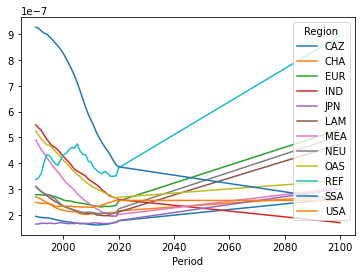

In [560]:
df_low.apply(lambda group: group.interpolate(method='linear')).pivot_table(values="Cycling", index="Period", columns="Region").plot()

In [ ]:
#2. road safety, we continue the trend of 1990 to 2019, not perfect but covers the recent GDP trend and regional specifics
df_acc = df_acc.merge(edgetransport[['period','region']], left_on=['Period','Region'], right_on=['period','region'], how ='right', suffixes=(False, False))
df_acc = df_acc.drop(columns=['Region','Period'])

#3. keep noise constant?
df_noise = df_noise.merge(edgetransport[['period','region']], left_on=['Period','Region'], right_on=['period','region'], how ='right', suffixes=(False, False))
df_noise = df_noise.drop(columns=['Region','Period'])

In [203]:
# put all together and through different mapping


edgetransport = edgetransport.merge(remind_tire, left_on=['technology_tires'], right_on=['Variable'], how ='left', suffixes=(False, False))
edgetransport = edgetransport.drop(columns=['Variable'])
edgetransport = edgetransport.merge(df_low, left_on=['period', 'region', 'technology_low'], how ='left', right_on=['period','Region','Variable'], suffixes=(False, False))
#remove region period and Variable
edgetransport = edgetransport.drop(columns=['Variable','Scenario'])


edgetransport = edgetransport.merge(df_acc_remind, left_on=['Period', 'Region', 'technology_acc'], how ='left', right_on=['period','region','Variable'], suffixes=(False, False))
edgetransport = edgetransport.drop(columns=['Variable','Scenario'])


edgetransport = edgetransport.merge(df_noise, left_on=['Period', 'Region', 'technology_noise'], how ='left', right_on=['period','region','Variable'], suffixes=(False, False))
edgetransport = edgetransport.drop(columns=['Variable','Scenario'])

edgetransport



,period,region,technology,cost,technology_low,technology_acc,technology_noise,technology_tires,Model,Unit_tire_plastice,Value_tire_plastic,Region,Period,Unit_low,Value_low,Unit_acc,Value_acc,Unit_noise,Value_noise
0,1990,IND,Compact Car,0.161233,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990,CHA,Compact Car,0.086830,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990,SSA,Compact Car,0.182402,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990,OAS,Compact Car,0.181293,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990,MEA,Compact Car,0.188524,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23563,2080,USA,Walk,9.622863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23564,2085,USA,Walk,9.833418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23565,2090,USA,Walk,10.046865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23566,2095,USA,Walk,10.265759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:


# check if everything is on the same unit

#EDGE needs 1990USD/pkm (1990USD/tkm)

# LCA is as vkm
## adjust LCA results to pkm with car_load_factor or take the car load factor from edge
edgetransport_load_factor = pd.read_csv(edgetransport_load_factor_path, sep=',')
edgetransport_load_factor =  edgetransport.merge(edgetransport_load_factor, left_on=['period', 'region', 'technology'], how ='left', right_on=['year','region','vehicle_type'], suffixes=(False, False))

edgetransport_load_factor['Value_low'] = edgetransport_load_factor['Value_low']/ loadFactor
edgetransport_load_factor['Value_acc'] = edgetransport_load_factor['Value_acc']/ loadFactor
edgetransport_load_factor['Value_noise'] = edgetransport_load_factor['Value_noise']/ loadFactor

#filter for variables
# non LCA is on pkm since calculated with remind results?




# everything is on cars and 
# differentiate or add surrogate truck (eg.40t) for freight to get per vkm and add to all road processes






,period,region,technology,cost,technology_low,technology_acc,technology_noise,technology_tires,Model,Unit_tire_plastice,...,Value_low,Unit_acc,Value_acc,Unit_noise,Value_noise,GDP_scenario,EDGE_scenario,year,loadFactor,vehicle_type
0,1990,IND,Compact Car,0.161233,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,gdp_SSP2,ElecEra,1990.0,2.500000,Compact Car
1,1990,CHA,Compact Car,0.086830,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,gdp_SSP2,ElecEra,1990.0,2.500000,Compact Car
2,1990,SSA,Compact Car,0.182402,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,gdp_SSP2,ElecEra,1990.0,2.499953,Compact Car
3,1990,OAS,Compact Car,0.181293,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,gdp_SSP2,ElecEra,1990.0,2.241181,Compact Car
4,1990,MEA,Compact Car,0.188524,NaN,Motor vehicle road injuries,Road,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,gdp_SSP2,ElecEra,1990.0,2.500000,Compact Car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23563,2080,USA,Walk,9.622863,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23564,2085,USA,Walk,9.833418,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23565,2090,USA,Walk,10.046865,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23566,2095,USA,Walk,10.265759,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
#Monetize

# load calc monetization
maybe even source the script


In [163]:



# write in a EDGE-T output file

,period,region,technology,cost,technology_low,technology_acc,technology_noise,technology_tires,Model,Unit_tire_plastice,Value_tire_plastic,Unit_low,Value_low,Unit_acc,Value_acc,Region,Period,Unit_noise,Value_noise


In [ ]:
# plot the PKM here xxxx
data.plot.bar()
plt.title('Impact total in ' + str(year))
plt.savefig("plot/impact_total_bike_share_"+str(bike_share)+'_'+str(year)+".pdf", bbox_inches='tight')
data.to_csv("data.csv")

In [ ]:
# also make per km with vkm?
# divide by vkm ?
# append all them to the data
# do it by vkm
# then put it to pkm
# add units
